In [1]:
import random
import numpy as np  
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.utils import Sequence

from keras.models import load_model, model_from_json
from keras.preprocessing import text
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras import backend as K
from keras import optimizers

import time
import datetime
import re
from scipy import spatial
from subprocess import Popen, PIPE, STDOUT
from difflib import SequenceMatcher
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

pd.options.display.max_colwidth = 200
%matplotlib inline

/home/dolmstead/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
region_dict = {0: "albuquerque", 1: "billings", 2: "calgary", 3: "charlotte", 4: "chicago", 5: "cincinnati", 6: "denver", 
               7: "houston", 8: "kansas city", 9: "las vegas", 10: "los angeles", 11: "minneapolis", 12: "montreal", 
               13: "nashville", 14: "new york", 15: "oklahoma city", 16: "phoenix", 17: "pittsburgh", 18: "san francisco", 
               19: "seattle", 20: "tampa", 21: "toronto", 22: "washington"}
range_to_region = {0: 3, 1: 4, 2: 5, 3: 7, 4: 10, 5: 13, 6: 14, 7: 15, 8: 18, 9: 19, 10: 20, 11: 21, 12: 22}
region_to_range = {3: 0, 4: 1, 5: 2, 7: 3, 10: 4, 13: 5, 14: 6, 15: 7, 18: 8, 19: 9, 20: 10, 21: 11, 22: 12}
df = pd.read_csv('data/tweets_labelled_balanced.csv', nrows=300000)
df.dropna(inplace=True)
df.region = df.region.astype(int)
df['text'] = df['text'].apply(lambda x:x.lower())
X = df['text'].tolist()
X2 = ["<s> "+x+" <e>" for x in X]
X3 = [x+" <e>" for x in X]
y = df['region'].tolist()
region_ids = np.unique(y)

# Set Parameters
training_ratio = .75
training_size = int(len(X)*training_ratio)
num_classes = 23
target_num_words = 10000
H = 500
epochs = 100
batch_size = 48
learning_rate = .0001
embedding_vector_length = 200

# Encode strings
t = text.Tokenizer(num_words=target_num_words, lower=True, char_level=False, filters='')

# Convert strings to sequences, pad them to uniform length, and divide up training and test sets
t.fit_on_texts(X2)
word_index = t.word_index
V = target_num_words + 2 #len(word_index)+1
index_word = {v: k for k, v in t.word_index.items()}
X_seq = t.texts_to_sequences(X)
X2_seq = t.texts_to_sequences(X2)
X3_seq = t.texts_to_sequences(X3)
x_length = max(len(x) for x in X2_seq)
X_padded = sequence.pad_sequences(X_seq, maxlen=x_length, padding='post')
X2_padded = sequence.pad_sequences(X2_seq, maxlen=x_length, padding='post')
X3_padded = sequence.pad_sequences(X3_seq, maxlen=x_length, padding='post')

X_train = X_padded[:training_size]
X2_train = X2_padded[:training_size]
X3_train = X3_padded[:training_size]
X_test = X_padded[training_size:]
X2_test = X2_padded[training_size:]
X3_test = X3_padded[training_size:]
y_train = y[:training_size]
y_test = y[training_size:]

## Load the Model

In [41]:
# Load Trained Model
from keras.models import load_model, model_from_json

model_name = 'Twitter_300k10k_1Bix1L'

model_weights = model_name+"_weights"
encoder_name = model_name+"_encoder"
decoder_name = model_name+"_decoder"
encoder_weights = encoder_name+"_weights"
decoder_weights = decoder_name+"_weights"

def load_model_weights(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

model = load_model_weights('models/{}.json'.format(model_name), 'models/{}.h5'.format(model_weights))
encoder_model = load_model_weights('models/{}.json'.format(encoder_name), 'models/{}.h5'.format(encoder_weights))
decoder_model = load_model_weights('models/{}.json'.format(decoder_name), 'models/{}.h5'.format(decoder_weights))

## Load Naive Bayes Model for Validation

In [7]:
NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vec = CountVectorizer()
train_vocab = vec.fit_transform(NB_X_train)
test_vocab = vec.transform(NB_X_test)

a = 0.5
mnb = MultinomialNB(alpha=a)
mnb.fit(train_vocab, NB_y_train)
mnb_predicted_labels = mnb.predict(test_vocab)
mnb_f1 = metrics.f1_score(NB_y_test, mnb_predicted_labels, average='weighted', labels=np.unique(mnb_predicted_labels))
mnb_acc = metrics.accuracy_score(NB_y_test, mnb_predicted_labels)

print("F1 score for alpha={}: {:.4f}, accuracy: {:.2f}% ".format(a, mnb_f1, mnb_acc*100))

F1 score for alpha=0.5: 0.2081, accuracy: 20.72% 


In [8]:
def get_nb_prediction(t, target=False):
    t = [t] if type(t) is not list else t
    vec_tweet = vec.transform(t)
    mnb_probs = mnb.predict_proba(vec_tweet)
    if target:
        return mnb_probs[:,region_to_range[target]] 
    else:
        predictions = mnb.predict(vec_tweet).reshape(1, len(t))
        probs = np.array([max(x) for x in mnb_probs]).reshape(1, len(t))
        return np.r_[predictions, probs]
    
tweet_list = ["if you're looking for work in va, check out this #job: #hiring #careerarc", 
              "i'm at cassell’s burgers in los angeles, ca",
              "go seahawks!",
              "dude i have a startup.  want to invest in electric scooters?"]

get_nb_prediction(tweet_list)

array([[22.        , 10.        , 19.        ,  5.        ],
       [ 0.80617513,  0.99923732,  0.49885963,  0.39939105]])

## Test the Model

### Evaluate Encoder Classifier

In [11]:
def get_lstm_prediction(source, target=False):
    ''' Given a sequence, get its predicted region and loss.'''
    if type(source) == str:
        source = t.texts_to_sequences([source])
    if type(source) == list:
        source = [np.squeeze(sequence.pad_sequences([x], maxlen=x_length, padding='post')) for x in source]
    layer_dict = dict([(layer.name, layer) for layer in encoder_model.layers])
    model_input = encoder_model.input
    model_output = layer_dict['encoder_dense'].output
    get_output = K.function([model_input], [model_output])
    results = get_output([source])[0]
    if target:
        return results[:,target]
    else:
        predictions = []
        probs = []
        for a in results:
            region = np.argmax(a)
            predictions.append(region)
            probs.append(a[region])
        return np.column_stack(([predictions, probs])).T

    
sample = X_padded[[2,3]]
get_lstm_prediction(sample, 10)

array([5.048666e-06, 9.941915e-02], dtype=float32)

In [8]:
indices = [random.randint(training_size, len(X)) for x in range(1000)]
tweets = np.array(X)[[indices]]
samples = X_padded[[indices]]
labels = np.array(y)[indices]
predictions = get_lstm_prediction(samples)
nb_predictions = get_nb_prediction(list(tweets))
d = {'tweets': tweets, 'labels': labels, 'lstm_pred': predictions[0].astype(int), 'lstm_certainty': predictions[1], 
     'nb_predictions': nb_predictions[0].astype(int), 'nb_certainty': nb_predictions[1]}
df_classtest = pd.DataFrame(data=d)
df_classtest[:10]

,tweets,labels,lstm_pred,lstm_certainty,nb_predictions,nb_certainty
0,"moved some stuff to philly and before i head back to new hope, dinner with #adayinthelifeofcarynblack @ gran caffe l'aquila",14,14,0.665680,14,0.968997
1,thought i was the only one noticing that. even the announcers haven’t picked up on it. giving them a full yard.,5,19,0.121096,5,0.287207
2,thinking about how lost i would be without the sacrament of reconciliation,5,14,0.091198,15,0.261699
3,is bill nelson from another planet. or did i see him on star trek?,13,13,0.093762,14,0.236754
4,sources - fear mongers - doesn’t matter- trumps got this. ⚔️🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸💪,4,21,0.296595,19,0.257861
5,y’all remember little alchemy?,18,7,0.134850,14,0.193095
6,"the word of god says in the later days ""what is right will be wrong, what is wrong will be right.""",3,18,0.120046,20,0.202187
7,"i'm at in seattle, wa",19,19,0.999741,19,0.999714
8,accident in #spartaky on i-71 sb at sparta pike #traffic,5,4,0.248554,14,0.301167
9,"it’s like, when you travel, you see the world so much bigger, and it looks so much smaller when you obligate to one zone.",10,18,0.097760,20,0.211722


Text(0.5,0.98,'300k Words 1L x 1L')

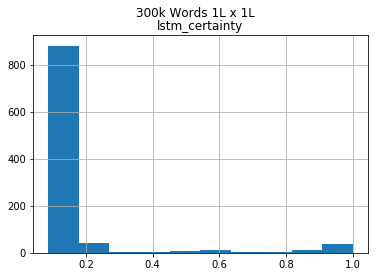

In [8]:
import pylab as pl
ax = df_classtest.hist(column='lstm_certainty', bins=10)
pl.suptitle("300k Words 1L x 1L")

Text(0.5,0.98,'300k Words')

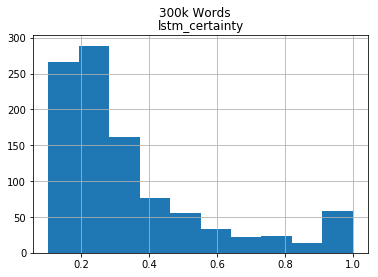

In [24]:
import pylab as pl
ax = df_classtest.hist(column='lstm_certainty', bins=10)
pl.suptitle("300k Words")

Text(0.5,0.98,'500k Words 5 epoch')

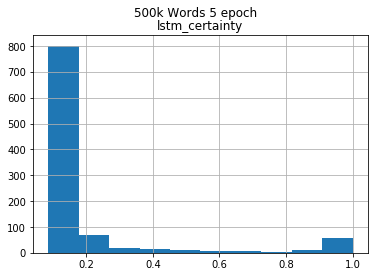

In [9]:
import pylab as pl
ax = df_classtest.hist(column='lstm_certainty', bins=10)
pl.suptitle("500k Words 5 epoch")

In [10]:
lstm_score = 0
nb_score = 0
concurrence = 0
for x in range(len(labels)):
    lstm_score += 1 if predictions[0][x] == labels[x] else 0
    nb_score += 1 if nb_predictions[0][x] == labels[x] else 0
    concurrence += 1 if nb_predictions[0][x] == predictions[0][x] else 0

print("LSTM Accuracy: {:.2f}% \nNB Accuracy: {:.2f}% \nConcurrence {:.2f}%"
      .format((lstm_score/len(labels))*100, (nb_score/len(labels))*100, (concurrence/len(labels))*100))

LSTM Accuracy: 18.70% 
NB Accuracy: 36.60% 
Concurrence 26.50%


### Evaluate Encoder/Decoder

In [12]:
# Quick spot-check the fidelity of the model (ie, that inputs/outputs match)
fidelity = check_fidelity_batch(X_test, 100)
fidelity[0][:10]

,Source,Decoded,Fidelity
0,coming from the biggest liar on earth define clear,coming from the biggest liar on earth create clear,0.963572
1,as knows he’s about to start playing he thinks he can hit me with there any new episodes u can 🙄,as well saying to be than him and worried he gets no more from u last mix of thx sorry,0.496379
2,drunk leaving ..,drunk leaving ..,1.000000
3,this high i am feeling is,this high i am feeling is,1.000000
4,fuck nudes send me pics of your dogs,fuck fucks me posting new talk your dogs,0.689398
5,what was your birthday wish 🎂 . may you find happiness and in your all your personal photos at,what was your birthday wish 😊 personal may know your happiness of yourself i have your full post today.,0.716491
6,just gone get me a little bottle and 😌,just gone get me a little bottle and 😌,1.000000
7,i agree with this there is no better place for solar than california. start here -&gt;,i agree with this there is no better place for infrastructure season. spending here tuned rn,0.765583
8,what’s his ig lmaoo,what’s his ig lmaoo,1.000000
9,everyday 😆,everyday 😆,1.000000


In [13]:
fidelity[1]

0.8271680706739426

### Evaluate Translator

In [42]:
# Spot-check a random tweet
ran = random.randint(0, len(X))
print("index: ", ran)
translate(X_padded[500], target=10, probs=True)

index:  89022


('this season the packers fans have zero room to talk shit about the bears or',
 '(chicago, 84.65%)',
 'this season fans the rams have gone to talk shit about the kiss the white',
 '(charlotte, 26.56%)')

In [30]:
# Batch-check the translation quality
pd.options.display.max_colwidth = 200
translate_batch(X_test[100:], target=10, num=10, probs=True)

,Source,Source_Prob,Translation,Translation_Prob
0,"i wanna cry so bad, i wanna cry so bad","houston, 38.26%",i filmed dad so fucken i wanna cry so high,"los angeles, 48.15%"
1,make it happen,"cincinnati, 9.46%",make it happen,"cincinnati, 9.46%"
2,was your home in the fire zone,"seattle, 15.35%",was your home in the fire 🔥,"seattle, 19.27%"
3,there is so much i want to say. i shared some of your religion so much. blaming me was easier than facing the the truth is what we all you for sharing your &amp; will gain from you &amp; hope othe...,"seattle, 46.17%","there is no reason i really to love, our bf of you. my nephew is nothing beyond me being blown up the people’s time i love what you are now thank you for each &amp; to it will welcome when you see...","houston, 25.69%"
4,we have 50 govt and people move happen every day and are not because of location or in or are not a we can focus on more than one issue at a,"seattle, 40.50%",we have 50 out and climate happen in all place has not be because of audio is or are always or a and more 101 look more than one point needs a,"seattle, 24.52%"
5,but what would that teach anyone,"cincinnati, 13.78%",but what would that stranger ed,"washington, 14.92%"
6,ward drives to the the pass around the yellow jacket and creates an easy basket for,"seattle, 29.75%",del cameras to the the hustle behind the polo pitch in creates perfect universal details. for,"seattle, 55.88%"
7,awww on my page that’s ghetto 😩,"tampa, 15.65%",awww on my favorite 🖤 😂😂😂😂😂😂 😩,"oklahoma city, 15.78%"
8,i’m looking forward to being in at the amazing grace baptist church in island sc for my good friend pastor david this,"charlotte, 94.71%","i’m heading great to being in my friends at the mission city queen in it, for all my friend uh david here:","los angeles, 16.98%"
9,and,"seattle, 8.14%",and ☹️,"seattle, 8.14%"


In [43]:
# 300k 1Bix1L
source = 'does anyone care that california is burning?'
source_pad = get_padded_sequence([source])[0]
predicted_region = get_lstm_prediction(source_pad)
print("Source tweet: {} ({}, {:.2f}%)".format(source, region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(source_pad, target=x, probs=True)
    print("{}".format(this_translation[2]))

Source tweet: does anyone care that california is burning? (los angeles, 0.21%)
does anyone care that prevent america does.
does anyone spending of that trump is aaron
does guilt adults that is living fault.
does anything family and change 🤫
does anyone care that is california closing
does anyone care that california is what happened.
does anyone care at what is lit
does anyone care is what we’re on hahaha
does anyone care that california is perfect.
does anyone care that is cleaning
does harm care that governor is hilarious.
does anyone care that comes now
does anyone care that is here?


In [15]:
# 300k 1Bix1L
source = 'fireflies are the best part of summer'
source_pad = get_padded_sequence([source])[0]
predicted_region = get_lstm_prediction(source_pad)
print("Source tweet: {} ({}, {:.2f}%)".format(source, region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(source_pad, target=x, probs=True)
    print("{}: {} {}".format(region_dict[x], this_translation[2], this_translation[3]))

Source tweet: fireflies are the best part of summer (seattle, 0.30%)
charlotte: () are the best part of summer (toronto, 13.39%)
chicago: #michigan are the best part of winter (toronto, 41.66%)
cincinnati: today. are the best part of blue (toronto, 14.52%)
houston: psa: are the best part of summer (houston, 13.43%)
los angeles: 😱 are the best part of summer (toronto, 13.39%)
nashville: indeed. are the best part of summer (toronto, 19.70%)
new york: indeed. are the best part of summer (toronto, 19.70%)
oklahoma city: lies. are the best part of summer now!! (seattle, 12.50%)
san francisco: remember, are the best part of autumn (toronto, 17.68%)
seattle: 😂🤣 are the best part of autumn (toronto, 18.12%)
tampa: exactly! are the best part of summer (washington, 12.36%)
toronto: ⚡️ are the best part of summer now!! (toronto, 12.27%)
washington: 1, are the best part of november (toronto, 15.92%)


In [35]:
# 300k 1Bix1L
source = "does anyone care that california is burning?"
source_pad = get_padded_sequence([source])[0]
predicted_region = get_lstm_prediction(source_pad)
print("Source tweet: {} ({}, {:.2f}%)".format(source, region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(source_pad, target=x, probs=True)
    print("{}: {} {}".format(region_dict[x], this_translation[2], this_translation[3]))

Source tweet: does anyone care that california is burning? (los angeles, 0.25%)
charlotte: dare anyone care that by is bitch! (new york, 28.21%)
chicago: does anyone any american is by hill, (new york, 16.30%)
cincinnati: does anyone wears that all is cindy (oklahoma city, 16.47%)
houston: does real 🤦🏾‍♀️ that r business equality (oklahoma city, 23.91%)
los angeles: does anyone feel that 🤓 music #maga (los angeles, 14.45%)
nashville: does anyone exclusive that for @ isis (tampa, 22.50%)
new york: does anyone care that as is 😹 (san francisco, 11.84%)
oklahoma city: does so... cares that god for arkansas (oklahoma city, 66.12%)
san francisco: does anyone care that california is 🙏 (san francisco, 49.21%)
seattle: does anyone else. that california are #seattle (seattle, 76.24%)
tampa: anyone does care no that is #goodmorning (tampa, 17.68%)
toronto: does anyone any that says is blues (chicago, 19.17%)
washington: mr problem offer that god is corporations (seattle, 15.17%)


In [82]:
# Translate a single tweet to every region
source = 500
predicted_region = get_lstm_prediction(X_padded[[500]])
print("Source tweet: {} ({}, {:.2f}%)".format(X[source], region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(X_padded[source], target=x, probs=True)
    print("{}: {} {}".format(region_dict[x], this_translation[2], this_translation[3]))

Source tweet: this season especially, the packers fans have zero room to talk shit about the bears or vikings. (chicago, 0.45%)
charlotte: this season the cowboys fans have another box to talk shit about the bayou or (houston, 65.38%)
chicago: this season the packers fans have zero room to talk shit about the bears or (chicago, 43.95%)
cincinnati: this season the packers fans have reduced place to ? talk to that bears or (chicago, 46.11%)
houston: this season the jake fans have cap outfit to talk shit about the bears or (chicago, 24.81%)
los angeles: this closer since the cowboys have loser makeup but talk to final is ugly a (tampa, 21.57%)
nashville: this season the #1 drew have zero room to talk shit about the bears or (chicago, 22.53%)
new york: this season the fans seem have left room to talk shit about the bears or (chicago, 23.55%)
oklahoma city: this season the packers fans have stuck , to work shit about bears @ or (chicago, 44.21%)
san francisco: this kings the warriors fans h

In [27]:
# Translate a single tweet to every region - 300k
source = 500
predicted_region = get_lstm_prediction(X_padded[[500]])
print("Source tweet: {} ({}, {:.2f}%)".format(X[source], region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(X_padded[source], target=x, probs=True)
    print("{}: {} {}".format(region_dict[x], this_translation[2], this_translation[3]))

Source tweet: this season especially, the packers fans have zero room to talk shit about the bears or vikings. (chicago, 0.55%)
charlotte: this season the panthers have gone sports room to talk shit about the bears or (charlotte, 38.55%)
chicago: this season the packers have zero room to talk fans about it the bears or anymore. (chicago, 87.67%)
cincinnati: this season the rams fans have happened to talk shit before the white team. (charlotte, 20.70%)
houston: this season the titans watched dallas have everything talk shit to throw about or not (oklahoma city, 68.40%)
los angeles: this season fans the rams have gone to talk shit about the kiss the white (charlotte, 26.56%)
nashville: this season the rams have the tv fans talk shit about to throw like (charlotte, 20.84%)
new york: this season fans the rams pub have to grill game about the fucking house. white (charlotte, 20.68%)
oklahoma city: this season the chiefs fans have flipped the talk about it loud to kill there (oklahoma city, 

### Build a test set
These fields are about creating the standardized test set of tweets to be used across models

In [15]:
test_set = {3: ['not true. but i hear you',
  'thursday isn’t coming fast enough i’m ready to eat',
  'awful first quarter again for the still can’t play a lick of defense and i don’t see the hustle i want to from these young players. no reason you should be tired this early.',
  'compare trump manufacturing numbers to kindly sit down. also return your prize for and step right up for a prize in',
  "why you should train like a if you're a | - if you're a your swim training might look very different than a competitive coach lindsey that shouldn't be the case.",
  'if only we had that espn cam',
  'the comments on this unc g ucla feed 😂😂😂😂',
  'with the sc on our chest',
  '➡️ for the 44 yard tech 7 ii georgia 28',
  "we're #hiring! read about our latest #job opening here: registered nurse - #rn sc"],
 4: ['is all about show and nothing about',
  'we are so thankful for everyone’s donations so far and we hope to gather even more food items for this holiday season. see salon for more details on how to earn a…',
  'well i would have never that! what was her favorite film of mine is probably the file on he was also with in sorry wrong number. i also liked it when bob made him into a in holiday',
  'temperature up -&gt; down -&gt; 7mph -&gt; 5mph',
  'a hint in the book of love to only one person never works out. in any and all the devil sees and the devil and justin are already married and enjoys the game of love',
  'at - drinking a vanilla porter by @ lake brewing company —',
  "i liked him, too. he just couldn't get right. had some great too. was the best (not for under but getting rid of greg might have been the worst bears move i've seen.",
  'crazy as this still sits in my mind how i supposedly gave a ring to someone just to shut her up. mind you i did it in if that was the case i done it here in illinois and not spent so much money to do it.',
  'i’m a fan of the chicago version of board game myself.',
  'can you recommend anyone for this #job in il? #nursing #hiring #careerarc'],
 5: ['made this for &amp; hope they like it',
  'being than you are literally at when it comes to knee space smh.',
  'one taught me love taught me one taught me pain',
  'i’m so thankful to have parents who are the greatest examples of love and they truly make an effort to love on everyone that their',
  'does anyone else’s heart drop at the sound of the garage door opening after you’ve done nothing all day? like oh shoot i have 20 seconds to get off my phone and look productive before my mom comes in',
  'if only notre dame could figure out how to a cowboys uniform and a bulls uniform into their fit for today’s game they’d complete the lame 90s fan',
  'may we all experience this joy at the end. is sweet, sad, but not - - @ indiana',
  'one could argue that no one brings more to a and therefore money to its football which turns into money for the school, which turns into money for a state than a head college football coach does.',
  'interested in a #job in #indianapolis, in? this could be a great fit: #hiring #careerarc',
  "big game. big implications. i'm picking #4 michigan to beat #10 ohio state in who you got? #goblue"],
 7: ['you want more you want free',
  'son, i had no idea i was paying for',
  'i’ll park how i want, if you got a problem call the call the gonna try me but y’all won’t break me.',
  'was gonna have a friendsgiving but into it so i’m just gonna sleep all day instead',
  'one of my coworkers said me to me and when i tell you i charged at this bitch 😂😂😂😂 thank u for grabbing me and putting me in the back n now the girl quit anyways bc she didn’t wanna work w me',
  "ain't gonna bum no money for you she ain't like that.. but she can put you on she scares the shit out of me.",
  'you want to be figure out how to keep big from going to austin or',
  'am trying to find a movie theatre in austin, texas area &amp; not',
  'my momma some serious mf went from letting me do what i want to tryna stop it , baby once u say it , ain’t no coming back from it sis ! so',
  'just posted a photo @ san antonio, texas'],
 10: ['she’s in love \U0001f970 with and',
  'not trying to scare you off friend',
  'there’s been a mass shooting. shut up about your stupid charger for 5 minutes.',
  'car got broken into i cannot trust street parking in la',
  'someone come and watch bohemian rhapsody with heard nothing but good things about that movie 🎥',
  'dear hollywood please give the roles of paul lindsey collins &amp; in this one scene from she proved she can channel all of them without a',
  'i haven’t been to santa monica in over a year. that used to be my spot 😩',
  'all i want for my birthday is for you to vote for me in the broadway world la i’m nominated for featured actress in a play - local for mr.',
  'last night this guy said i looked like jordan and i laughed and he’s like seriously you do, i know her im a in beverly i said hook it up then 😭😂',
  'san ca thu nov 8th am forecast: today sunny hi tonight clear'],
 13: ['you can tell a lot by a',
  'this is kicking my ass. hope i can hit the doctor instead of the',
  'god - ft. (official music video) via',
  'thank god. some people don’t need on having class. i married an eastern european for that reason.',
  'and it’s 7 bra i’m bout to gts',
  'the edited karma album on apple music didn’t get edited bruh',
  'atlanta we got another chance at a championship. in our @',
  'nashville to become home of east coast of \r\n',
  'finished nashville and now i don’t know what to watch 😕',
  'interested in a #job in #huntsville, al? this could be a great fit: #microsoft #hiring #careerarc'],
 14: ['day by starting to understand the',
  'i voted for on stream music from apple music',
  'two of our lady tucker and james will be signing their on thursday at at',
  'get these vegan castle this sunday at ’s vegan sunday. we’ll have some of your other favorites on the menu too.',
  'throw back last #turkey @ pennsylvania',
  'ceo of sustainable energy for all rachel the new of global energy and “the energy systems are going to be very different in the she said, and',
  'accident in on us 23 nb at #traffic',
  'accident in on pkwy nb at',
  'mark your - #givingtuesday is nov just 1 week from today! please join me in helping make boston the urban population by supporting my run with \r\n\r\n',
  "i'm at - station in nj"],
 15: ['should i call u ? 🤔',
  "let's go out for a drink",
  'watching for the time just to see my boo mr.',
  'a 5th round pick should have had the luxury of 3 or 4 years on the practice no 5th round pick gets thrown to the wolves like this kid was. i wish him great luck , he’s a class act',
  'cowboys with red - soon to be a mini clutch 😍 i’ve been this forever 😂',
  "want to work at we're #hiring in tx! click for details: #marketing #job #jobs",
  'i cast my heisman ballot for #tuatagovailoa! click the player you think deserves the heisman house vote. (📍)',
  "we're #hiring! click to apply: database admin i - #it #houston, tx #job #jobs #careerarc",
  'our #clerical team is hiring at in #tulsa, ok! click the link to learn more today #job #hiring #careerarc',
  'can you recommend anyone for this #job? director of retail operations - #supplychain #dallas, tx #hiring'],
 18: ['he was as good as not as strong, but had more',
  'the christmas playlist is fire i’m thinking about getting a tree wow',
  ', and gunna killing all the features this',
  'my uber just dropped me off a block away and drove right past me while sticking a middle finger smfh',
  "people bring national artist here often. but it's like even if and when you open for that's it. theres no conversations theres no email exchange theres not even social media exchange something that could equal opportunity down the road.",
  'whose air and other announced it raised $20 million in series b funding on nov',
  'can you recommend anyone for this #job in ca? #psjhjobs',
  "press members are setting up in for #trump to arrive here at air force military wasn't able to if president trump would be answering questions on the #campfire or if he'd simply land to then board a",
  'want to work in ca? view our latest opening: #hospitality #job #jobs #hiring #careerarc',
  "we're #hiring! click to apply: special education teacher and hard of hearing - #education #reno, nv #job #jobs #careerarc"],
 19: ['don’t there are more of us 😂',
  "if you're interested in a blog about the clothes on you can find them at",
  'in 3 weeks, i’m gonna be back on the west side with my all time favorite people who i haven’t seen in months &amp; i couldn’t be more excited @ washington',
  "want to work at match we're #hiring in on! click for details: #marketing #job #jobs #careerarc",
  'anniversary spotlight 9 years of music place great songs from year year seven &amp; fourth - to - tears of pleasure -',
  'i always called them sweet pants cuz i wear them to go down a block for my donut fix',
  '💞 gives a great big “thank you” to for us in better serving our 💋 sexual wellness and education is our #1 priority at',
  'vote! (@ king county administration building in seattle,',
  'not feeling the rain but mom says i’ll be happy i wore it after our walk #pnw',
  'unwanted person at block of sw 12th ave, portland, or [portland police #pdx911'],
 20: ['&amp; and old is not enough',
  'i just turned on fox and whose face do i see and greg how can you say you respect you turned into a bigger asshole than before.',
  'yep, the democratic firing squad has as',
  'sounds like a weird cookie handling issue. wonder if trying another would help?',
  'leaving any doubt about how crooked everyone in trump’s inner circle is: former trump lawyer michael cohen guilty to lying to in deal with mueller',
  'evil democrats steal elections by encouraging many, many people to vote and then have audacity to make sure their votes are',
  'in florida on holiday from the uk was up most of the night reading woke up 2 hours ago praying i’d wake to find that fucking oh the joy of being in your country to watch it happen. home tomorrow so hurry up please. 😀',
  "want to work at kelly services? we're #hiring in #orlando, fl! click for details: #kellyjobs #kellyservices #clerical #job #jobs #careerarc",
  'happy 90th birthday mickey mouse !',
  'andrew gillum let’s bring this home! #florida #miami'],
 21: ["if you're wondering they are last video",
  'are we screwed on the over yet?',
  '2018 beauty monthly all products are &amp; have a mix of full sized',
  "5 game winning streak for thanks to tom wilson it makes this team alot better the way they're playing this season. they may have lot some good players from injuries but no worries they'll make their return soon stay focus and be aggressive by all means",
  "we're #hiring! read about our latest #job opening here: wireless team member - #retail #newyork, ny",
  'attended doug god space workshop at church and it was want your people to love and listen, invite',
  'sabres should try and get from the whatever we would have to give up would be worth it',
  'school of public health alum kate presents from her @ understanding the access &amp; of sexual &amp; health care among young adults from a study',
  'enter the #goatblackfriday raffle for your chance to win the most coveted sneakers and other prizes.',
  'new 🔥🔥 link in bio \r\n @ toronto, ontario'],
 22: ['',
  'nope. just too fucked up. you need to read carl to understand',
  'adults jokes in that you totally missed as a kid',
  'we are holding a #career event on in come meet our #hiring team and apply today! #projectmgmt #veterans #job #jobs #careerarc',
  'donald the con is lying . neither russia or china can sell military to saudis . it does not with american technology . he is lying through his teeth to save his personal business interests in saudi arabia . don the con is at it again -',
  'join the group team! see our latest #job opening here: #it nj #hiring #careerarc',
  'be a part of a progressive organization dedicated to the of our and the communities we all call home. follett is now hiring for a team member (part time &amp; full time) in #job #jobs #hiring #careerarc',
  'follett is improving the world by inspiring learning and education. want to join the experience follett and apply today as a team member (part time &amp; full time) in in. #job #jobs #hiring #careerarc',
  'can you recommend anyone for this #job in va? #nursing #hiring #careerarc',
  "want to work at virginia department of we're #hiring in va! click for details: #definedbenefits #job #jobs #careerarc"]}

In [48]:
# Build a subset of tweets, one from every region and at every confidence level of regional prediction (measured by Naive Bayes)
subset = {3: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          4: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          5: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          7: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          10: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          13: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          14: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          15: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          18: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          19: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          20: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          21: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''},
          22: {0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: ''}}

def is_full(d):
    # Is the dictionary full?
    for region, ranks in subset.items():
        for rank, tweet in ranks.items():
            if len(tweet) == 0:
                return False
    return True

for x in range(1, 10):
    tweets = NB_X_test[:x*1000]
    NB_seqs = t.texts_to_sequences(tweets)
    V_filtered_tweets = [decode_padded_sequence(np.array(x)) for x in NB_seqs]
    predictions = get_nb_prediction(V_filtered_tweets)
    for p in range(len(V_filtered_tweets)):
        prob = predictions[1][p]
        cat = int((prob*100-(prob*100%10))/10)
        reg = int(predictions[0][p])
        if cat < 10 and len(V_filtered_tweets[p].split()) > 5:
            subset[reg][cat] = V_filtered_tweets[p]
    if is_full(subset):
        break

In [46]:
subset

{3: {0: 'not true. but i hear you',
  1: 'wins the second set over',
  2: 'save me x meek mill',
  3: 'some of y’all panthers fans need to get off his wtf is wrong with you',
  4: 'in other news, ou women’s basketball lost to clemson in the jam in the by a score of',
  5: 'thanks for signing the the panthers are i’ll bet most of the coaches don’t agree with this the panthers have no heart because of',
  6: 'i get the constitution and all that that’s democratic that’s somebody had the balls to say women had the right to took a stand for civil when they weren’t popular and against the democratic quiet 20 cabinet',
  7: "if you're looking for work in wilmington, check out this #job: #construction #hiring #careerarc",
  8: 'i’m #allin for the which did you vote for in the rivalry week',
  9: 'can you recommend anyone for this #job in greenville, sc? #accounting #hiring #careerarc'},
 4: {0: 'i only know how to drive on i-5 now,',
  1: 'working out without music is just awful',
  2: 'it did

In [49]:
condensed_subset = {}
for region, ranks in subset.items():
    tweetlist = []
    for rank, tweet in ranks.items():
        tweetlist.append(tweet)
    condensed_subset[region] = tweetlist
condensed_subset

{3: ['not true. but i hear you',
  'thursday isn’t coming fast enough i’m ready to eat',
  'awful first quarter again for the still can’t play a lick of defense and i don’t see the hustle i want to from these young players. no reason you should be tired this early.',
  'compare trump manufacturing numbers to kindly sit down. also return your prize for and step right up for a prize in',
  "why you should train like a if you're a | - if you're a your swim training might look very different than a competitive coach lindsey that shouldn't be the case.",
  'if only we had that espn cam',
  'the comments on this unc g ucla feed 😂😂😂😂',
  'with the sc on our chest',
  '➡️ for the 44 yard tech 7 ii georgia 28',
  "we're #hiring! read about our latest #job opening here: registered nurse - #rn sc"],
 4: ['is all about show and nothing about',
  'we are so thankful for everyone’s donations so far and we hope to gather even more food items for this holiday season. see salon for more details on how 

### Run the test set on this model

In [16]:
# Retranslate a tweet back to source region and get cosine similarity of embedded vectors
df_scores = pd.DataFrame(columns=['Source', 'Target', 'Decile', 'Original', 'Translation', 'Trans Region', 'Trans BLEU', 
                                  'Retranslation', 'Retrans Region', 'Retrans BLEU'])
trans_score = 0
retrans_score = 0
    
for i in range(len(region_ids)):
    start_time = time.time()
    print("working on region ", i)
    source = region_ids[i]
    target = region_ids[i+1] if i+1 < len(region_ids) else region_ids[0]
    test_seq = t.texts_to_sequences(test_set[source])
    test_padded = sequence.pad_sequences(test_seq, maxlen=x_length, padding='post')

    for x in range(10):
        print(x)
        original = test_padded[x]
        translation = translate(original, target)[1]
        retranslation = translate(translation, source)[1]
        original_sentence = decode_padded_sequence(original)
        translated_sentence = decode_padded_sequence(translation)
        retranslated_sentence = decode_padded_sequence(retranslation)
        trans_bleu = get_bleu_score(original_sentence, translated_sentence)
        retrans_bleu = get_bleu_score(original_sentence, retranslated_sentence)
        trans_region = int(get_lstm_prediction(translation)[0][0])
        retrans_region = int(get_lstm_prediction(retranslation)[0][0])
        trans_score += 1 if trans_region==target else 0
        retrans_score += 1 if retrans_region==source else 0

        df_scores.loc[10*i + x] = [region_dict[source], region_dict[target], x, original_sentence, translated_sentence, 
                            region_dict[trans_region], trans_bleu, retranslated_sentence, region_dict[retrans_region], 
                            retrans_bleu]
    end_time = time.time()
    run_time = datetime.timedelta(seconds=end_time-start_time)
    print("Finished in {}".format(run_time))
    
df_scores

working on region  0
0
1
2
3
4
5
6
7
8
9
Finished in 0:00:11.935694
working on region  1
0
1
2
3
4
5
6
7
8
9
Finished in 0:00:20.057795
working on region  2
0
1
2
3
4
5
6
7
8
9
Finished in 0:00:33.657937
working on region  3
0
1
2
3
4
5
6
7
8
9
Finished in 0:00:47.835662
working on region  4
0
1
2
3
4
5
6
7
8
9
Finished in 0:01:04.001725
working on region  5
0
1
2
3
4
5
6
7
8
9
Finished in 0:01:22.244086
working on region  6
0
1
2
3
4
5
6
7
8
9
Finished in 0:01:37.904728
working on region  7
0
1
2
3
4
5
6
7
8
9
Finished in 0:01:55.771255
working on region  8
0
1
2
3
4
5
6
7
8
9
Finished in 0:02:13.535092
working on region  9
0
1
2
3
4
5
6
7
8
9
Finished in 0:02:31.869462
working on region  10
0
1
2
3
4
5
6
7
8
9
Finished in 0:02:49.312064
working on region  11
0
1
2
3
4
5
6
7
8
9
Finished in 0:03:06.420462
working on region  12
0
1
2
3
4
5
6
7
8
9
Finished in 0:03:26.136047


,Source,Target,Decile,Original,Translation,Trans Region,Trans BLEU,Retranslation,Retrans Region,Retrans BLEU
0,charlotte,chicago,0,not true. but i hear you,"does we go, especially the festive cast look",chicago,0,"don’t come determine we're especially the tomorrow night, 💕",chicago,0
1,charlotte,chicago,1,thursday isn’t coming fast enough i’m ready to eat,being placed check forward competitive especially for can’t fit the there's,toronto,0,"being ready cash again. stay especially for please, go 👀 #httr 😌",nashville,0.192591
2,charlotte,chicago,2,awful first quarter again for the still can’t play a lick of defense and i don’t see the hustle i want to from these young players. no reason you should be tired this early.,"timing again 3rd to was we get 2nd on the or of toys or see how they are! the world, and of course in this year’s gets to keep me in the never miss it period.",chicago,0.280797,"timing to pick the i will get go starting at our or they love donald of course, panther is weird. 4th is in it’s cool and better for it. and i’ll play osu again this game? 😘",nashville,0.287931
3,charlotte,chicago,3,compare trump manufacturing numbers to kindly sit down. also return your prize for and step right up for a prize in,"fear. local turnout thinks to check it, finishing year, and it's free goal a or needs to amazing tree. in",toronto,0.24463,"deals wise under it, hope to help 8 if trump check vs and has spot at this same for compliance 😂😂😂 #hospitality #job",charlotte,0.252398
4,charlotte,chicago,4,why you should train like a if you're a | - if you're a your swim training might look very different than a competitive coach lindsey that shouldn't be the case.,dont i often let a in the sun say you're your mess. thanks if it needs a short pass. great teams make better and qb style players. we deserve the game is #gocougs,chicago,0.264901,"dont do , not a in my or will down change. we need a big game! so steelers will allow him this team gets better, and play one, yeah. play a first",charlotte,0.223815
5,charlotte,chicago,5,if only we had that espn cam,if they show the only yesterday you’ll play,cincinnati,0.235673,btw they came the you ain’t board lol,houston,0
6,charlotte,chicago,6,the comments on this unc g ucla feed 😂😂😂😂,the idea by our 2nd 4th ou talent bday 😤,new york,0.195528,the step east mr. vs vip upgrade miss in they’re performing 😤 @…,oklahoma city,0.191123
7,charlotte,chicago,7,with the sc on our chest,with the night! of downtown,new york,0.19483,the happy of week are gorgeous in playoff for,oklahoma city,0.196924
8,charlotte,chicago,8,➡️ for the 44 yard tech 7 ii georgia 28,seed just to #nyc jv first 8 senior magic xc game,chicago,0,gravy have to mac (@ university detroit rose in casino sc 🙏🏾,charlotte,0
9,charlotte,chicago,9,we're #hiring! read about our latest #job opening here: registered nurse - #rn sc,i'm if all cnn in our newest ag currently set up 1 and such,new york,0.189681,"fuck us i’ll see our scott first friends, hiring in for longer up games 🙄 #careerarc",nashville,0.186905


In [20]:
df_scores = pd.read_csv('Twitter_300k10k_1Bix1L_scores.csv')
trans_score = sum(df_scores["Target"] == df_scores["Trans Region"])
retrans_score = sum(df_scores["Source"] == df_scores["Retrans Region"])

In [18]:
print("Translation accuracy: {:.2f}% \nRetranslation accuracy: {:.2f}% \nOverall translation accuracy: {:.2f}%"
      .format((trans_score/130)*100, (retrans_score/130)*100, ((trans_score+retrans_score)/260)*100))
print("Average BLEU translation score: {:.2f} \nAverage BLEU Retranslation score: {:.2f}"
      .format(np.mean(df_scores['Trans BLEU']), np.mean(df_scores['Retrans BLEU'])))

Translation accuracy: 56.92% 
Retranslation accuracy: 65.38% 
Overall translation accuracy: 61.15%
Average BLEU translation score: 0.21 
Average BLEU Retranslation score: 0.18


In [42]:
trans_score = df_scores["Target"] == df_scores["Trans Region"]
retrans_score = df_scores["Source"] == df_scores["Retrans Region"]
better_retrans = sum(trans_score & retrans_score)
better_retrans/130

0.3153846153846154

In [23]:
df_scores[df_scores['Decile'] > 7]

,Source,Target,Decile,Original,Translation,Trans Region,Trans BLEU,Retranslation,Retrans Region,Retrans BLEU
8,charlotte,chicago,8,➡️ for the 44 yard tech 7 ii georgia 28,"line, for the discount up nd tech jumped 9 years",chicago,0.198264,“i’m for the discount up tech jumped 9 tech changed earlier,charlotte,0.190350
9,charlotte,chicago,9,we're #hiring! read about our latest #job opening here: registered nurse - #rn sc,"we're #hiring! read about our latest #job opening here: registered nurse , puppy - friends. tf",toronto,0.666895,"we're #hiring! read about our latest registered nurse about our puppy , - registered sc love",charlotte,0.358313
18,chicago,cincinnati,8,i’m a fan of the chicago version of board game myself.,i’m a fan of the fan of the early game smh,charlotte,0.381633,haven’t a fan of the fan to the game experience,oklahoma city,0.251329
19,chicago,cincinnati,9,can you recommend anyone for this #job in il? #nursing #hiring #careerarc,can you recommend anyone for this #job in oh? sales #accounting #careerarc,cincinnati,0.631555,can you recommend anyone for this #job in ia? #kellyjobs #kellyservices #manufacturing #careerarc,chicago,0.576084
28,cincinnati,houston,8,"interested in a #job in #indianapolis, in? this could be a great fit: #hiring #careerarc","interested in a #job in #indianapolis, this #job in that - make you #careerarc",cincinnati,0.350048,"interested in a #job in #indianapolis, this #job in such a you would",cincinnati,0.350644
29,cincinnati,houston,9,big game. big implications. i'm picking #4 michigan to beat #10 ohio state in who you got? #goblue,big losses lol. worried beat oklahoma beating #10 to beat ohio state in texas who you got? shit!,oklahoma city,0.256346,"big losses and, beat down. beat #4 ohio state beat #4 ohio state beat in who brady",cincinnati,0.218221
38,houston,los angeles,8,"my momma some serious mf went from letting me do what i want to tryna stop it , baby once u say it , ain’t no coming back from it sis ! so","my cousins had fun telling me to see ur friends ... i'm gonna do it take yo shit lmao. i don’t care how much went out to us , it already thank kyle 😭❤️",los angeles,0.291802,"my cousins had fun telling me to see shit , it comes to me n they just can’t take yo shit .. so much to tell me , just take care ok baby 💕",houston,0.283335
39,houston,los angeles,9,"just posted a photo @ san antonio, texas","just posted a photo @ san antonio, texas",houston,1.000000,"just posted a photo @ san antonio, texas",houston,1.000000
48,los angeles,nashville,8,"last night this guy said i looked like jordan and i laughed and he’s like seriously you do, i know her im a in beverly i said hook it up then 😭😂",last night this guy came i saw and gus looked like talking and i said “this is like i never touched my phone if you think in my car it up al period.,nashville,0.124769,last night this saw guy i saw and said looked like my hubby said it’s like i never watched and now besides “this is i like me he needs a dude in the…,los angeles,0.134882
49,los angeles,nashville,9,san ca thu nov 8th am forecast: today sunny hi tonight clear,san francisco thu nov becoming ca today sunny hi tonight at,san francisco,0.273768,"san diego dear ave, ca / today #photoshoot @ hurricane",los angeles,0.210683


In [19]:
df_scores.to_csv('Twitter_300k10k_1Lx1L_2drop_12e.csv', index=False, mode='w', header=True)

In [5]:
def check_fidelity(source):
    return (decode_padded_sequence(source), decode_padded_sequence(predict_sequence(source)[0]))

def cosine_similarity(emb1, emb2):
    return 1 - spatial.distance.cosine(emb1, emb2)

def check_fidelity_batch(source_array, num):
    translator_results = {'Source':[], 'Decoded':[], 'Fidelity': []}
    fidelities = []
    for _ in range(num):
        source_embeddings = get_embeddings(source_array[_])
        translation = predict_sequence(source_array[_], translate=False)
        translation_embeddings = get_embeddings(translation)
        fidelity = cosine_similarity(source_embeddings, translation_embeddings)
        translator_results['Source'].append(decode_padded_sequence(source_array[_]))
        translator_results['Decoded'].append(decode_padded_sequence(translation))
        translator_results['Fidelity'].append(fidelity)
        fidelities.append(fidelity)
    df_fidbatch = pd.DataFrame.from_dict(translator_results)[['Source', 'Decoded', 'Fidelity']]
    fidscore = np.mean(fidelities)
    return (df_fidbatch, fidscore)

def translate(source, target, probs=False):
    return_string = False
    if type(source) == str:
        source_sentence = source
        source_sequence = t.texts_to_sequences([source])
        source_padded = sequence.pad_sequences(source_sequence, maxlen=x_length, padding='post')
        return_string = True
    else:
        source_sentence = decode_padded_sequence(source)
        source_padded = source
    if probs:
        source_sentence = source_sentence
        source_prediction = get_nb_prediction(source_sentence)
        source_probstring = "({}, {:.2f}%)".format(region_dict[source_prediction[0][0]], source_prediction[1][0]*100)
        target_sentence = decode_padded_sequence(predict_sequence(source_padded, translate=target))
        target_prediction = get_nb_prediction(target_sentence)
        target_probstring = "({}, {:.2f}%)".format(region_dict[target_prediction[0][0]], target_prediction[1][0]*100)
        return  (source_sentence, source_probstring, target_sentence, target_probstring)
    else:
        if return_string:
            return (source_sentence, decode_padded_sequence(predict_sequence(source_padded, translate=target)))
        else:
            return (source_padded, predict_sequence(source_padded, translate=target))

def translate_batch(source_array, target, num, probs=False):
    translator_results = {'Source':[], 'Source_Prob': [], 'Translation':[], 'Translation_Prob':[]}
    for _ in range(num):
        translation = translate(source_array[_], target, False)
        source_sentence = translation[0] if type(translation[0])==str else decode_padded_sequence(translation[0])
        translated_sentence = translation[1] if type(translation[1])==str else decode_padded_sequence(translation[1])
        translator_results['Source'].append(source_sentence)
        translator_results['Translation'].append(translated_sentence)
    if probs:
        source_probs = get_nb_prediction(translator_results['Source'])
        trans_probs = get_nb_prediction(translator_results['Translation'])
        for x in range(len(translator_results['Source'])):
            translator_results['Source_Prob'].append("{}, {:.2f}%".format(region_dict[source_probs[0][x]], 
                                                                            source_probs[1][x]*100))
            translator_results['Translation_Prob'].append("{}, {:.2f}%".format(region_dict[trans_probs[0][x]], 
                                                                            trans_probs[1][x]*100))       
        return pd.DataFrame.from_dict(translator_results)[['Source', 'Source_Prob', 'Translation', 'Translation_Prob']]
    else:
        return pd.DataFrame.from_dict(translator_results)[['Source', 'Translation']]

def predict_sequence(source, translate=False, beam=False):
    '''
    Given a source array, feed it through the autoencoder to predict a string - either itself in the naive case 
    where translation is turned off, or run gradient ascent to convert the source array to a target category,
    and run that through the autoencoder to get the translated version.
    '''
    source = source.reshape(1, x_length)
    # feed the source into the encoder inference model
    encode = encoder_model.predict(source)
    
    # If set to translate, run gradient ascent to maximize to the target_label
    if translate:
        state = gradient_ascent(source, encoder_model, translate)
        decode_sequence = decode_latent(state, source=source, target_cat=translate, beam=beam)
        if beam:
            optimized_sequence = optimize(source, decode_sequence[1], translate)
            while len(optimized_sequence) < x_length:
                optimized_sequence = np.append(optimized_sequence, 0)
            return (decode_sequence[0], optimized_sequence)
    else:
        state = encode[1:]
        decode_sequence = decode_latent(state)
    
    return decode_sequence

def normalize(x):
    # utility function to normalize a tensor by its L2 norm, used to scale gradient ascent
    # return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
    return x / K.max(x)

def gradient_ascent(seq, model, target, show_steps=False, step_rate=.5, target_prob=.9):
    '''
    Run gradient ascent to maximize a sequence to a target category.  Returns final state values.
    '''
    target_probability = target_prob # You want the model to be this certain the string is in the target category
    
    # Identify the target model layers and tensors for input and output
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    lstm_input = layer_dict['encoder_lstm_1'].input # Use the layer that accepts the embeddings
    model_input = model.input
    
    loss = K.mean(model.output[0][:, target]) # The loss value for the target category
    states = K.identity(model.output[1:]) # The h, c values for this iteration
    grads = K.gradients(loss, lstm_input)[0] # The gradients for the lstm_input layer w/respect to the loss
    grads = normalize(grads) # Play with this function to scale the speed of the ascent
    
    # Define input/output functions
    get_embeddings = K.function([model_input], [lstm_input])
    run_ascent = K.function([lstm_input], [loss, grads, states])

    # Input sequence to model to initiate the ascent
    embeddings_value = get_embeddings([seq])[0]
    
    # Iterate through the model until loss exceeds target probability
    counter = 0
    while counter < 20:
        loss_value, grads_value, states_value = run_ascent([embeddings_value])
        target_shape = states_value.shape[2]
        return_value = [np.reshape(states_value[0][0], (1,target_shape)), np.reshape(states_value[1][0], (1,target_shape))]
        if show_steps:
            print("{}. ({:.2f}) {}".format(counter, loss_value, decode_padded_sequence(decode_latent(return_value))))
        if loss_value > target_probability and not show_steps: # Exit the ascent
            return return_value if not show_steps else "Complete"
            break
        elif loss_value <= 0.: # Some inputs can zero out the loss
            break
        else:
            grads_value = grads_value * step_rate
            embeddings_value += grads_value
            counter += 1

def decode_latent(state, source=None, target_cat=None, beam=False):
    '''
    Given a pair of state vectors, run iteratively through the decoder to build an output sequence.
    Returns the padded output sequence of the most likely sentence, unless 'beam_search' is set
    to True, in which case it returns the most probably sequence and an array of the top 5 most
    likely sequences as a tuple.
    '''
    # start of sequence input
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = 1 # Start Character index
    output_seq = list()
    output_array = np.ones((5,1), dtype=int)
    stop = False
    word_counter = 1
    while not stop:
        output_tokens, h, c = decoder_model.predict([target_seq] + state)
        output_tokens = output_tokens[0, -1, :]

        # Sample the top n tokens
        top_tokens = np.argpartition(output_tokens, -6)[-6:]
        top_tokens = top_tokens[np.argsort(output_tokens[top_tokens])][::-1]
        top_token = top_tokens[0]

        # Exit if sampled character is end token or we've reached max length
        decoded_char = index_word[top_token] if top_token > 0 else ''
        if (decoded_char == '<e>' or word_counter + 1 == x_length):
            stop = True
            break

        # If we haven't reached the end of the sentence...
        output_seq.append(top_token)
        top_tokens = np.expand_dims(top_tokens, axis=1)
        if word_counter > 1:
            output_array = np.concatenate((output_array, top_tokens), axis=1)
        else:
            output_array = top_tokens

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = top_token

        # Update states and counter
        state = [h, c]
        word_counter += 1
    
    while len(output_seq) < x_length:
        output_seq.append(0)
    return (np.array([output_seq]), output_array) if beam else np.array([output_seq])


def beam_search(source, dec_array, target_cat, tag_weight=0):
    '''
    Given a source sequence and a an array of the top-5 potential words for each position from the decoder,
    optimize the potential words into the best five sentences according to both target region score
    and part-of-speech tag similarity.  'tag_weight' is set between -1 (full weight to regional score) to
    1 (full weight to tag similarity--NOT IMPLEMENTED).
    '''
    target_tags = pos_tagger([decode_padded_sequence(source[0])])
    buffer = dec_array[:,0].reshape(5,1)
    for i in range(1, dec_array.shape[1]):
        candidates = None # build the list of 25 new candidate sentences
        for j in dec_array[:,i]: # iterate through the next top 5 words
            for k in buffer: # for each of the top 5 previous sentences
                candidate = k.copy()
                candidate = np.append(candidate, j)
                if candidates is not None:
                    candidates = np.vstack([candidates, candidate])
                else:
                    candidates = candidate

        # From the 25 candidates, narrow down to the top 5
        sentences = []
        for c in candidates:
            sentences.append(decode_padded_sequence(c))
        tag_score = match_tags(sentences, target_tags[0][:i])
        cat_score = get_nb_prediction(sentences, target_cat)
        sen_score = (tag_score + cat_score) / 2
        top_sequences = np.argpartition(sen_score, -5)[-5:]
        top_sequences = top_sequences[np.argsort(sen_score[top_sequences])][::-1]
        top_5_sequences = candidates[top_sequences]
        buffer = top_5_sequences
    return buffer

def pos_tagger(tweets):
    ''' Fetch the Part-of-Speech tags for this text from the CMU Tweet Tagger.'''
    tags = []
    p = Popen('java -XX:ParallelGCThreads=2 -Xmx500m -jar ~/ark-tweet-nlp/ark-tweet-nlp-0.3.2.jar --no-confidence', 
                   stdin=PIPE, shell=True, stderr=PIPE, stdout=PIPE)
    stdout_data = p.communicate(input='\n'.join(tweets).encode())[0].decode("utf-8")
    stdout_data = stdout_data.split('\n')
    p.kill()
    for response in stdout_data[:-1]:
        tag_string = response.split('\t')[1]
        tags.append(tag_string)
    return tags

def get_embeddings(seq):
    ''' Given a sequence, get the word embeddings for this model'''
    layer_dict = dict([(layer.name, layer) for layer in encoder_model.layers[1:]])

    model_input = layer_dict['encoder_embedding'].input
    embedding_layer_output = encoder_model.layers[1].output
    lookup_embeddings = K.function([model_input], [embedding_layer_output])
    embeddings = lookup_embeddings([seq])[0].flatten()

    return list(embeddings)

def decode_padded_sequence(seq):
    seq = seq.flatten()
    return " ".join([index_word[x] for x in seq if x > 0])

def get_padded_sequence(sentence_list):
    # Given a sentence string, return the padded sequence of index numbers according to the tokenizer
    response = []
    for s in sentence_list:
        s_seq = [word_index[x] for x in s.split()]
        s_padded = sequence.pad_sequences([s_seq], maxlen=x_length, padding='post')
        response.append(s_padded)
    return response

def similar(a, b):
    return SequenceMatcher(None, a, b).quick_ratio()

def match_tags(taglist, target):
    tags = pos_tagger(taglist)
    return np.array([similar(x, target) for x in tags])

def get_bleu_score(ref, hyp):
    ref = ref.split()
    hyp = hyp.split()
    cc = SmoothingFunction()
    return sentence_bleu([ref], hyp, smoothing_function=cc.method4)

## Gradient Ascent

In [21]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm, used to scale gradient ascent
    # return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
    return x / K.max(x) 

In [15]:
ga_text = "interested in a #job in #indianapolis, in? this could be a great fit: #construction #careerarc"
ga_pad = get_padded_sequence([ga_text])[0]

In [22]:
# Show the steps for gradient ascent
gradient_ascent(ga_pad, encoder_model, 14, show_steps=True)

0. (0.00) interested in a #job in #indianapolis, in? this could be a great fit: #construction #careerarc
1. (0.10) interested in a #job in #indianapolis, in? this could be a great fit: #construction 😑
2. (0.71) interested in a #job in smarter things. this week be a great fit: #construction #brooklyn
3. (1.00) interested in a #job in people fall this team be a great fit: #construction #careerarc
4. (1.00) interested in a #job in movies in? this could be a great fit: #brooklyn #careerarc
5. (1.00) updated: in a professor in movies towards this be looking a great fit: #engineering #careerarc
6. (1.00) incident in a theater about in starring this looking be a great fit: garden #careerarc
7. (1.00) hey in a theater in here in a great looking this great to garden
8. (1.00) shoutout in a we're in here starring this be the great photo to #brooklyn
9. (1.00) hi, in a omg this live thinking - be in a great garden tunnel
10. (1.00) hi, in a yes, at best heading in our new want a garden ❄️
11. (1.

In [130]:
valid_text = "this season the packers fans have zero room to talk shit about football"
valid_pad = get_padded_sequence([valid_text])[0]
get_lstm_prediction(valid_pad)

array([[4.        ],
       [0.26001632]])

In [131]:
get_nb_prediction(valid_text)

array([[4.        ],
       [0.46890921]])

## Beam Search

In [86]:
region_ids

array([ 3,  4,  5,  7, 10, 13, 14, 15, 18, 19, 20, 21, 22])

In [270]:
df_optimized = pd.DataFrame(columns=['Target Region', 'Raw Translation', 'Raw Region', 'Raw BLEU', 'Optimized', 'Optimized Region', 'Optimized BLEU'])
source = "this season the packers fans have zero room to talk shit about football"
source_pad = get_padded_sequence([source])[0]
for i in range(4):
    result = predict_sequence(source_pad, translate=region_ids[i], beam=True)
    raw = decode_padded_sequence(result[0])
    optimized = decode_padded_sequence(result[1])
    print(optimized)
    probs = get_lstm_prediction([result[0].flatten(), result[1].flatten()])
    prob_raw = "{} ({:.2f}%)".format(region_dict[probs[:,0][0]], probs[:,0][1])
    prob_opt = "{} ({:.2f}%)".format(region_dict[probs[:,1][0]], probs[:,1][1])
    bleu_raw = get_bleu_score(source, raw)
    bleu_opt = get_bleu_score(source, optimized)
    df_optimized.loc[i] = [region_dict[region_ids[i]], raw, prob_raw, bleu_raw, optimized, prob_opt, bleu_opt]

df_optimized

season season the packers fans booked kickoff any like .... shit about hating
this buckeyes the packers fans booked zero any like w shit about football
better buckeyes the kickoff fans swing zero could @ like shit about football
this season the season fans booked zero cum like bs shit about football


,Target Region,Raw Translation,Raw Region,Raw BLEU,Optimized,Optimized Region,Optimized BLEU
0,charlotte,this season the panthers have zero room to talk shit about football rip,charlotte (0.56%),0.670342,season season the packers fans booked kickoff any like .... shit about hating,los angeles (0.21%),0.229975
1,chicago,this season the packers have zero talk to smoke up shit about football,chicago (0.47%),0.327746,this buckeyes the packers fans booked zero any like w shit about football,chicago (0.84%),0.294631
2,cincinnati,this luck the buckeyes fan tickets have going to talk today... love about,cincinnati (0.88%),0.210614,better buckeyes the kickoff fans swing zero could @ like shit about football,cincinnati (0.67%),0.193878
3,houston,this season the football fans have the tv shit too talk about curse,houston (0.22%),0.237451,this season the season fans booked zero cum like bs shit about football,nashville (0.54%),0.294631


In [157]:
result = predict_sequence(source_pad, translate=3, beam=True)
print(decode_padded_sequence(result[0]))
print(decode_padded_sequence(result[1]))
print(get_lstm_prediction([result[0].flatten(), result[1].flatten()]))

this season the panthers have zero room to talk shit about football rip
this season the packers fans have zero room to talk shit about football
[[ 3.         15.        ]
 [ 0.56213653  0.24867183]]


In [98]:
get_lstm_prediction([result[0].flatten()])

array([[4.        ],
       [0.24154189]])

In [137]:
translate(X_padded[500], target=18, probs=True)

('this season the packers fans have zero room to talk shit about the bears or',
 '(chicago, 88.68%)',
 'this season the packers have we’re starting some noise talk about the paradise bears or',
 '(chicago, 59.84%)')

In [238]:
source = 'this season the packers fans have zero room to talk shit about football'
source_pad = get_padded_sequence([source])[0]
#sample = decode_padded_sequence(X_padded[500])
target_tags = pos_tagger([source])
target_cat = 14
trans_seq = np.squeeze(predict_sequence(source_pad, translate=target_cat))

In [239]:
encoded_state = encoder_model.predict(source_pad)[1:]
translated_state = gradient_ascent(source_pad, encoder_model, target_cat)
output_array = decode_latent(translated_state, beam=True)[1]

In [72]:
original_tweet = []
original_tweet.append(source.split())
original_tweet.append(list(target_tags[0]))
pd.DataFrame(original_tweet)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,this,season,the,packers,fans,have,zero,room,to,talk,shit,about,the,bears,or
1,D,N,D,^,N,V,$,N,P,V,N,P,D,N,&


In [79]:
pos_tagger(['a rams the rams haters have 10:30 silence at talk shit on the kisses or'])

['D N D ^ N V $ N P V N P D N &']

In [272]:
optimized_seq = optimize(source_pad, output_array, 10)
print(decode_padded_sequence(optimized_seq))
print(get_lstm_prediction([optimized_seq]))

[0.11264158 0.05065152 0.07906037 0.04000871 0.05260401 0.06522468]
[0.06092572 0.06050765 0.07991237 0.03641217 0.05689863 0.06363926
 0.05315892 0.01524762 0.07159621 0.00126319]
[0.07557963 0.03398203 0.05960976 0.05000822 0.10395222 0.01587498
 0.03229915 0.06793313 0.00679322]
[0.02944408 0.04887762 0.03743482 0.1307459  0.029997   0.03492201
 0.01533661 0.00712519]
[0.15843584 0.06352947 0.07177497 0.18657494 0.09248181 0.04602351
 0.12859397 0.04250889 0.03183252]
[0.08965816 0.05704065 0.05761851 0.09529788 0.06066105 0.05794299
 0.05633201 0.06611985 0.05130152 0.07968061 0.03124708]
[0.06384703 0.10910004 0.10379287 0.12329155 0.08811045 0.08909667
 0.11710026 0.07503431 0.01855014 0.06469356]
[0.08415735 0.0776779  0.09248716 0.08299492 0.0678471  0.09454718
 0.06854571 0.07891688 0.1013145  0.06677256]
[0.07178104 0.0819746  0.0891635  0.07040597 0.12191088 0.07634122
 0.08934772 0.10451528 0.05160993 0.08022628 0.07059372 0.06241238]
this season the football fans booked ze

In [271]:
def get_cols(a, c):
    '''return column c from array a as well as the columns on either side'''
    st = c-1 if c > 0 else 0
    en = c+1 if c < a.shape[1] else a.shape[1]
    return np.unique(output_array[:,st:en].flatten())

def optimize(source_pad, output_array, target_cat):
    source_sentence = decode_padded_sequence(source_pad)
    taglist = pos_tagger([source_sentence])[0].split()
    rebuilt = []
    for col in range(output_array.shape[1]):
        options = get_cols(output_array, col)
        if source_pad[0][col] in options: # If the original word is in the options, weight it heavily 
            source_options = []
            for o in options: # Make a new list of all the possible sentences ending in this list
                temp = rebuilt.copy()
                temp.append(o)
                if source_pad[0][col] == o:  # Put the source option at the front
                    source_options.insert(0, temp)
                else:
                    source_options.append(temp)
            source_regions = get_lstm_prediction(source_options, target_cat)
            print(source_regions)
            if source_regions[np.argmax(source_regions)] > source_regions[0] * 3:
                best = np.argmax(source_regions)
            else:
                best = 0
            rebuilt = source_options[best]
            continue
        else: # source word isn't in options, move on to plan B: choose matching tags
            decoded_options = []
            seq_options = []
            for o in options: # Make a new list of all the possible sentences ending in this list
                temp = rebuilt.copy()
                temp.append(o)
                decoded_options.append(decode_padded_sequence(np.array(temp)))
                seq_options.append(temp)
            tagged_options = pos_tagger(decoded_options)
            filtered_seqs = []
            filtered_sens = []
            if col < len(taglist):
                for tag_i in range(len(tagged_options)):
                    if tagged_options[tag_i].split()[-1] == taglist[col]:
                        filtered_seqs.append(options[tag_i])
                        filtered_sens.append(decoded_options[tag_i])
                if source_pad[0][col] in options and source_pad[0][col] not in filtered_seqs:
                        filtered_seqs.append(source_pad[0][col])
                        filtered_sens.append(index_word[source_pad[0][col]])         
            if filtered_seqs:
                region_options = []
                for o2 in filtered_seqs:
                    temp = rebuilt.copy()
                    temp.append(o2)
                    region_options.append(temp)
                best = np.argmax(get_lstm_prediction(region_options, target_cat))
                rebuilt = list(region_options[best])
                continue
            else:  # There is no matching tag from among the options.  Just add the most likely word.''
                best = np.argmax(get_lstm_prediction(seq_options, target_cat))
                rebuilt = seq_options[best]
    return np.array(rebuilt)

In [132]:
output_array

array([[  14,  337,    3, 3266,   23, 1839,  523,    4,  291,  110,   44,
         495, 1427],
       [ 159, 3266,  705, 4303,  705,  413,  705,  705,  705, 1046,   73,
         392,  392],
       [   3,  439,  337, 2566,  138, 2772, 2772,  291, 6983, 1754,  119,
         573, 1020],
       [  16,  730, 3266,  495,  648, 1360, 4779,  676, 2371,   73,  256,
         705, 9590],
       [   6,  159,  160, 3536,   77, 1703, 3534,  339, 2945,  603,  705,
        6503,  619],
       [  77,  160,  287,  705,  337, 1946,  291, 2772,  397,  705,   38,
        1427,  608]])

Original: 'sabres should try and get from the whatever we would have to give up would be worth it' (21, 99%)
Loosest: 'cavs didn’t try and getting to all for you knew would to would it would would it' (5, 35%)
'cavs didn’t try and getting to all trade you would knew to would him would would get' (21, 31%)
'cavs didn’t try and getting to all you knew would to would would would much' (5, 34%)
'sabres should try and get to the we would knew to give would would much' (21, 99%)
'sabres should try and get to the anything we would knew to give him would get much' (21, 99.7%)

In [245]:
trial = get_padded_sequence(['this season the packers fans'])[0].flatten()
get_lstm_prediction([trial])

array([[4.        ],
       [0.41815203]])

In [246]:
the = get_padded_sequence(['this season the buckeyes'])[0].flatten()
a = get_padded_sequence(['this season the packers'])[0].flatten()
this = get_padded_sequence(['this season the eagles'])[0].flatten()


In [207]:
three = np.squeeze(sequence.pad_sequences([[3]], maxlen=x_length, padding='post'))
six = np.squeeze(sequence.pad_sequences([[6]], maxlen=x_length, padding='post'))
fourteen = np.squeeze(sequence.pad_sequences([[14]], maxlen=x_length, padding='post'))
np.argmax(get_lstm_prediction([three, six, fourteen], 18))

2

In [248]:
get_lstm_prediction([the, a, this], 14)


array([0.02995912, 0.01463577, 0.24134514], dtype=float32)

In [242]:
# working table
word_table = []
for x in output_array:
    word_table.append(decode_padded_sequence(x).split(" "))

pd.DataFrame(word_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,this,playing,the,buckeyes,fans,kickoff,to,be,there,bs,about,shit,football,players.
1,better,season,season,eagles,game,zero,out,have,bs,w,talk,damn,sports,yet.
2,playing,football,football,season,season,on,at,cum,no,...,no,hating,espn,🤦‍♂️
3,the,game,eagles,football,kickoff,without,have,any,like,n,shit,dude,vs.,today?
4,season,buckeyes,missed,packers,swing,at,could,10pm,@,....,w,hell,thing,👌
5,playoffs,running,buckeyes,kickoff,football,booked,any,has,...,shit,than,talk,radio,blue.


In [63]:
# 300k word table
word_table = []
for x in output_array:
    word_table.append(decode_padded_sequence(x).split(" "))

pd.DataFrame(word_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,this,season,fans,the,rams,have,gone,to,talk,shit,about,the,kiss,the,white
1,a,fans,the,going?,chargers,fans,to,on,fucking,fucking,with,you’re,embarrassment,of,or
2,ever,weekend,tickets,"tonight,","tonight,",🏈,silence,fucking,fuck,with,the,them,booty,in,age
3,the,football,weekend,watched,steelers,"tonight,",10:30,toast,tears,fuck,on,to,heart,a,state
4,that,rams,panthers,rams,tl,lost.,anxiety,of,bed,about,up,what’s,fake,or,racist
5,it,panthers,rams,lost.,haters,gone,frfr,at,grill,you’re,and,kiss,kisses,house,orange


In [33]:
# 500k 5-epoch word table
word_table = []
for x in output_array:
    word_table.append(decode_padded_sequence(x).split(" "))

pd.DataFrame(word_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,this,season,the,fans,you're,not,an,show,up,space,me,time,football
1,the,the,you're,reason,be,no,full,tv,to,excitement,shit,football,#mondaynightfootball
2,it’s,fair,us,you're,stand,have,great,showing,space,?,to,here,#mentalhealth
3,we,finished,a,cheering,vote,get,playing,theme,out,deeper,ya,games,😅
4,all,"saturday,",fans,reminder,make,that,one,florida,with,night,remember,during,blessing.
5,a,all,to,voted,don't,a,winning,games,around,stuff,you,hearing,events.


In [40]:
# 500k 7-epoch word table
word_table = []
for x in output_array:
    word_table.append(decode_padded_sequence(x).split(" "))

pd.DataFrame(word_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,this,season,the,packers,fans,have,price,job,to,talk,shit,about,football
1,the,starting,a,bulls,detroit,available,box,finds,can,comedy,story,every,day.
2,an,blows,onto,fans,challenge,more,early,away,friends,reality,n,hours,every
3,next,storm,storm,detroit,tend,are,available,room,when,conversation,christmas,at,night.
4,a,clear,listen,bears,host,holiday,longer,find,who,tell,“,this,wrestling
5,final,pretty,packers,storm,certainly,early,short,interview,from,pop,girl,bc,sports


In [231]:
tag_table = []
for x in output_array:
    tag_table.append(list(pos_tagger([decode_padded_sequence(x)])[0]))

pd.DataFrame(tag_table)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,D,,N,,D,,N,,V,,...,,V,,N,,P,,N,,G
1,R,,^,,N,,^,,N,,...,,N,,N,,D,,N,,N
2,D,,R,,N,,^,,N,,...,,N,,A,,P,,N,,N
3,O,,V,,^,,N,,N,,...,,^,,D,,P,,N,,N
4,D,,R,,A,,N,,V,,...,,V,,A,,N,,N,,N
5,V,,A,,V,,N,,N,,...,,V,,N,,P,,V,,V


In [186]:
editor = get_embeddings(word_index['editor'])
case = get_embeddings(word_index['editor'])
1 - spatial.distance.cosine(editor, case)

1.0

In [180]:
from pyjarowinkler import distance
seq_test = seq_sample.copy()
seq_test = list(filter(lambda a: a != 0, seq_test))
output = output_array[:,0].reshape(6,1)
for i in range(1, output_array.shape[1]):
    candidates = None # build the list of 25 new candidate sentences
    for j in output_array[:,i]: # iterate through the next top 5 words
        #if j == seq_test[i]:  # if the original word is in the top 5 options, just use that
        #    output.append(j)
        #    break
        for k in output: # for each of the top 5 previous sentences
            candidate = k.copy()
            candidate = np.append(candidate, j)
            if candidates is not None:
                candidates = np.vstack([candidates, candidate])
            else:
                candidates = candidate

    # From the 25 candidates, narrow down to the top 5
    sentences = []
    for c in candidates:
        sentences.append(decode_padded_sequence(c))
    tag_score = match_tags(sentences, target_tags[0][:i])
    #tag_score = [distance.get_jaro_distance(x, target_tags[0][:i]) for x in sentences]
    cat_score = get_nb_prediction(sentences, target_cat)
    sen_score = (tag_score + cat_score) / 2
    top_sequences = np.argpartition(sen_score, -5)[-5:]
    top_sequences = top_sequences[np.argsort(sen_score[top_sequences])][::-1]
    top_5_sequences = candidates[top_sequences]
    output = top_5_sequences
            

for x in output:
    print(decode_padded_sequence(x), get_nb_prediction(decode_padded_sequence(x)))

a trend is be a good at at nj case - overnight #job [[14.        ]
 [ 0.98502154]]
a trend is be a good at at nj case - overnight #jobs [[14.        ]
 [ 0.98471988]]
a trend is be a good at at nj case - overnight #hiring [[14.        ]
 [ 0.98462544]]
a trend is be a good at at nj case - overnight #careerarc [[14.        ]
 [ 0.98432697]]
a trend is be a great at at nj case - overnight #job [[14.        ]
 [ 0.98432426]]


In [139]:
seq_test

[17, 29, 345, 500, 3, 3129, 8019, 3125]

In [166]:
get_nb_prediction('shout out to the girl who saw the place at home and had 12 song on netflix also')

array([[10.        ],
       [ 0.17354419]])

In [ ]:
def optimize(source_pad, output_array, target_cat):
    source_sentence = decode_padded_sequence(source_pad)
    taglist = list(pos_tagger(source_sentence)[0])
    rebuilt = []
    for col in range(output_array.shape[1]):
        options = get_cols(output_array, col)
        if source_pad[0][col] in options: # Just use the original word if it's an option
            rebuilt.append(source_pad[0][col])
        else: # choose matching tags
            decoded_options = []
            for o in options:
                temp = rebuilt.copy()
                temp.append(o)
                decoded_options.append(decode_padded_sequence(np.array(temp)))
            tagged_options = pos_tagger(decoded_options)
            filtered_seqs = []
            if col < len(taglist):
                for tag_i in range(len(tagged_options)):
                    if tagged_options[tag_i][-1] == taglist[col]:
                        filtered_seqs.append(options[tag_i])
            if filtered_seqs:
                region_options = []
                for o2 in filtered_seqs:
                    temp = rebuilt.copy()
                    temp.append(o2)
                    region_options.append(temp)
                best = np.argmax(get_lstm_prediction(region_options, target_cat))
                rebuilt = region_options[best]
            else:  # There is no matching tag from among the options.  Just add the most likely word.''
                region_options = []
                for o2 in options:
                    temp = rebuilt.copy()
                    temp.append(o2)
                    region_options.append(temp)
                best = np.argmax(get_lstm_prediction(region_options, target_cat))
                rebuilt = region_options[best]
    return np.array(rebuilt)